# LSTM Neural Network Closing Price Prediction

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from pandas_datareader import data, wb
import pandas_ta as ta
import yfinance as yf
yf.pdr_override()

from datetime import date as date
import datetime as dt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, LSTM, TimeDistributed

import tensorflow as tf
import keras
from keras import optimizers
from keras.callbacks import History
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Activation, Dropout
from tensorflow.keras.optimizers import Adam

In [2]:
ticker = 'GOOGL'
start = dt.datetime (2010,1,1)
end = dt.date(2023,12,31)
today = date.today()

In [3]:
stock = pd.DataFrame(data.get_data_yahoo(ticker, start))

[*********************100%%**********************]  1 of 1 completed


In [4]:
stock.head(3)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,15.689439,15.753504,15.621622,15.684434,15.684434,78169752
2010-01-05,15.695195,15.711712,15.554054,15.615365,15.615365,120067812
2010-01-06,15.662162,15.662162,15.174174,15.221722,15.221722,158988852


In [5]:
stock.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3597 entries, 2010-01-04 to 2024-04-18
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       3597 non-null   float64
 1   High       3597 non-null   float64
 2   Low        3597 non-null   float64
 3   Close      3597 non-null   float64
 4   Adj Close  3597 non-null   float64
 5   Volume     3597 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 196.7 KB


In [6]:
# Indicators
stock['RSI'] = ta.rsi(stock['Close'], length = 15)
stock['EMAF'] = ta.ema(stock['Close'], length = 20)
stock['EMAM'] = ta.ema(stock['Close'], length = 100)
stock['EMAS'] = ta.ema(stock['Close'], length = 150)

stock['Target'] = stock['Adj Close'] - stock['Open']
stock['Target'] = stock['Target'].shift(-1)

stock['Target Class'] = [1 if stock['Target'][i] > 0 else 0 for i in range (len(stock))]

stock['Target Next Close'] = stock['Adj Close'].shift(-1)

stock.dropna(inplace=True)
stock.reset_index(inplace=True)
stock.drop(['Volume', 'Close', 'Date'], axis=1, inplace=True)


C:\Users\teddy\AppData\Local\Temp\ipykernel_24864\235826474.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stock['Target Class'] = [1 if stock['Target'][i] > 0 else 0 for i in range (len(stock))]


In [7]:
data_set = stock.iloc[:, 0:11]
pd.set_option('display.max_columns', None)
data_set.head(5)

,Open,High,Low,Adj Close,RSI,EMAF,EMAM,EMAS,Target,Target Class,Target Next Close
0,12.647648,12.656156,12.413664,12.518018,57.784344,12.207696,12.656134,13.144912,0.077577,1,12.646396
1,12.568819,12.650150,12.546547,12.646396,59.994903,12.249477,12.655941,13.138309,0.034035,1,12.605355
2,12.571321,12.662663,12.476727,12.605355,58.937824,12.283370,12.654940,13.131250,-0.149899,0,12.305806
3,12.455706,12.462462,12.299800,12.305806,51.800342,12.285507,12.648026,13.120317,0.201952,1,12.312563
4,12.110611,12.381131,12.074825,12.312563,51.940998,12.288083,12.641383,13.109618,-0.066316,0,12.170921


In [8]:
sc = MinMaxScaler(feature_range=(0,1))
data_set_scaled = sc.fit_transform(data_set)
print(data_set_scaled)

[[0.00939295 0.00855314 0.00829952 ... 0.46741394 1.         0.00934627]
 [0.00885887 0.00851279 0.00921007 ... 0.46438652 1.         0.00906925]
 [0.00887582 0.00859687 0.00873164 ... 0.45159777 0.         0.0070473 ]
 ...
 [1.         0.99341564 0.98252675 ... 0.47662061 1.         0.96618246]
 [0.96836018 0.96929519 0.97457812 ... 0.45159121 0.         0.973405  ]
 [0.97804856 0.97890308 0.98245827 ... 0.50860439 1.         0.97704995]]


In [9]:
X = []

backcandles = 30  # Numbers of days from the past data to predit future price
print(data_set_scaled.shape[0])

for j in range(8): 
    X.append([])
    for i in range(backcandles, data_set_scaled.shape[0]):
        X[j].append(data_set_scaled [i - backcandles: i, j])  # Model's input data from 8 columns (Open to EMAS)

X = np.moveaxis(X, [0], [2])

X, yi = np.array(X), np.array(data_set_scaled[backcandles:, -1])  # Predicting the last column (Target-Next-Close)

y = np.reshape(yi, (len(yi), 1))

print(X.shape)
print(y.shape)

3447
(3417, 30, 8)
(3417, 1)


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


print (X_train.shape)
print (X_test.shape)
print (y_train.shape)
print (y_test.shape)

(2733, 30, 8)
(684, 30, 8)
(2733, 1)
(684, 1)


In [11]:
model = Sequential()

model.add (LSTM(180, input_shape=(backcandles, 8), name='first_layer')) 
model.add (Dense(1, name='dense_layer')) 

model.add (Activation('linear', name='output'))

adam = Adam()
model.compile(optimizer=adam, loss='mse')

In [12]:
model.fit(X_train, y_train, batch_size=40, epochs=35, shuffle=True, validation_data=(X_test, y_test))

Epoch 1/35

69/69 [==============================] - 6s 36ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 2/35
69/69 [==============================] - 2s 26ms/step - loss: 1.1818e-04 - val_loss: 0.0024
Epoch 3/35
69/69 [==============================] - 2s 25ms/step - loss: 1.0252e-04 - val_loss: 0.0018
Epoch 4/35
69/69 [==============================] - 2s 25ms/step - loss: 9.1195e-05 - val_loss: 0.0019
Epoch 5/35
69/69 [==============================] - 2s 26ms/step - loss: 8.8024e-05 - val_loss: 0.0016
Epoch 6/35
69/69 [==============================] - 2s 25ms/step - loss: 8.6187e-05 - val_loss: 0.0014
Epoch 7/35
69/69 [==============================] - 2s 26ms/step - loss: 8.6900e-05 - val_loss: 0.0022
Epoch 8/35
69/69 [==============================] - 2s 26ms/step - loss: 9.0717e-05 - val_loss: 9.5899e-04
Epoch 9/35
69/69 [==============================] - 2s 25ms/step - loss: 8.5719e-05 - val_loss: 0.0011
Epoch 10/35
69/69 [==============================] - 2s 25ms/step - loss

<Axes: >

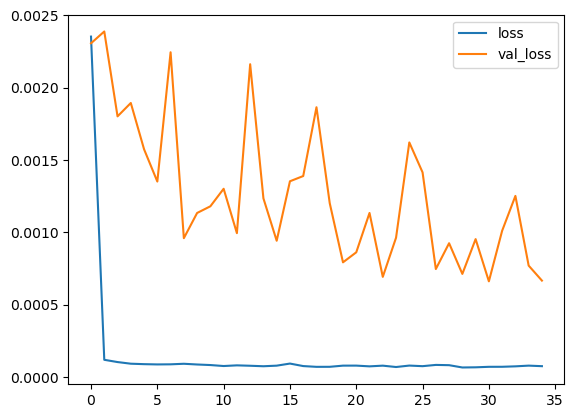

In [13]:
losses = pd.DataFrame(model.history.history)
losses.plot()

In [14]:
y_pred = model.predict(X_test)
for i in range (10):
    print (y_pred[i], y_test[i])

22/22 [==============================] - 1s 14ms/step
[0.8279599] [0.83338647]
[0.83333975] [0.83425051]
[0.8297151] [0.83948511]
[0.8307754] [0.83607973]
[0.8338813] [0.84368017]
[0.8330903] [0.84021742]
[0.8381242] [0.84814528]
[0.83731365] [0.84742987]
[0.8423469] [0.84386587]
[0.8449338] [0.85004207]


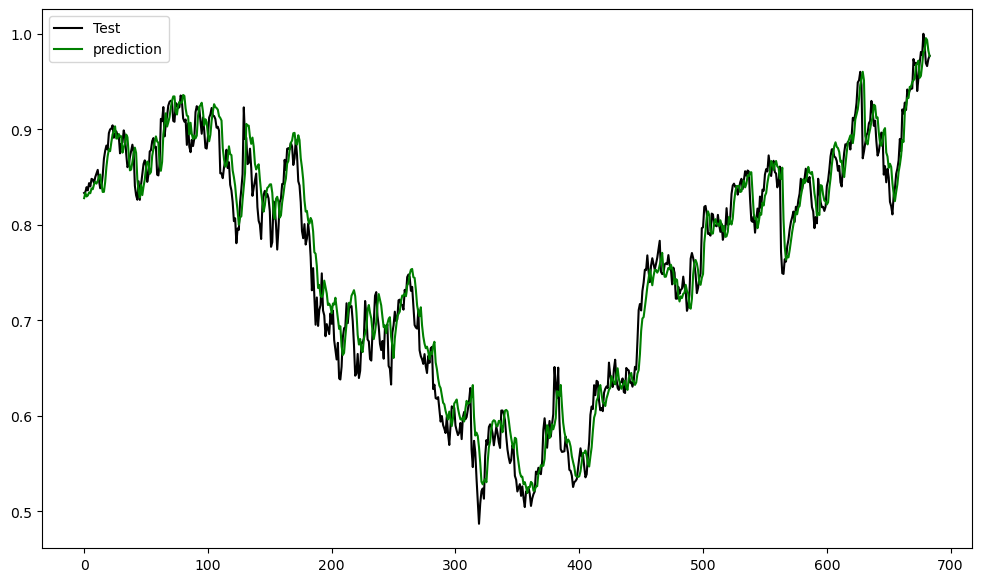

In [15]:
plt.figure(figsize=(12,7))
plt.plot (y_test, color='black', label='Test')
plt.plot (y_pred, color='green', label='prediction')
plt.legend()
plt.show()

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 first_layer (LSTM)          (None, 180)               136080    
                                                                 
 dense_layer (Dense)         (None, 1)                 181       
                                                                 
 output (Activation)         (None, 1)                 0         
                                                                 
Total params: 136261 (532.27 KB)
Trainable params: 136261 (532.27 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
